# Python project for the scientific programming course
## Classification of normal vs tumoral samples
Analysis of the TCGA gene expression data with classification techniques

## Outcome 
1) Analyze the input file, such the percentage of the healthy and tumoral samples, ...
2) Split the data into train and test sets. If you need a validation set, further split the train into
train and validation sets.
3) Run different classification techniques and compare them by using different evaluation
metrics (accuracy, precision, recall, ...).
4) Optional: Use k-fold cross validation for the analysis

# Preliminary analysis of the data

## Downloading the data
All the data for this notebook is downloaded from [GenoSurf](http://geco.deib.polimi.it/genosurf/).
Once on the page in the link the following fields have ben set:
- Management section
    - Source : tcga
    - Project name : tcga-brca
- Extraction section
   - Data type : gene expression quantification
   - Assembly : grch38
- Biology section
    - Healthy/Control/Normal : [false | true]

The process was done two times one using Healthy/Control/Normal : false and another Healthy/Control/Normal : true.

Clicking on "RESULT ITEMS" then on "DOWNLOAD LINKS" and then "DOWNLOAD" a file containing the links for the individual data files is downloaded.

Then, using the command provided on the GenoSurf popup that opens when you try to download the links the actual files are downloaded in two separate directories to separate control from diseased data. The command is `xargs -L 1 curl -J -O -L < files.txt`


## Loading the data
Because of the limited resources at my disposal and the great amount of data to be processed the loading process will be divided into distinct parts
1) Load a subset of the data that can be comfortably held in memory and do a preliminary analysis to understand the more important genes for the problem at hand
2) Check if the results from the previous step are coherent with the biological question 
3) Load the full dataset excluding the genes that were deemed not important for the problem at hand
4) Write the new transformed dataset so that the lengthy steps of computation and transformations can be executed only 1 time

This should make possible to load the full dataset with the relevant features without exceeding the amount of RAM available to me. 
At the end of the process the file data_top_100_genes.txt is created and contains the wide format for the FPKM levels for each patient in the dataset.

### Loading the subset and deciding which genes to use
All the data from the patients that are healthy will be loaded and 300 of the diseased patients. After loading this data and organizing it in a pandas DataFrame as sklearn wants it (observation by row and the columns are the features) the univariate mutual information for each gene will be calculated and only the top 100 will be retained.

This operation will produce a file containing the Ensembl gene ids of the best 100 genes according to the scoring system.

The next section can take quite some time to run. It's a good time to get a cup of coffee or tea.

#### Configuration

If this is not the first time running the notebook the data has already been processed to the final usable format and you can decomment the line initializing the variable `data_needs_processing = True` and commenting the one that initializes it to `False`



In [1]:
data_needs_processing = True
#data_needs_processing = False

The tests were executed on a PC with 16GB of RAM available closing any other program not needed during the tests and sometimes the notebook would restart for lack of memory. The amount of free memory needed to complete the task appears to be around 6/7 GB. If you encounter such problem or are using a PC with a lower amount of RAM please consider lowering the value of the variable `max_samples` Please, be aware that doing so the outcome of the analysis could have some minor change.

In [2]:
max_samples = 300

The following variable contains the paths to the folders containing the data files. Please modify them according to the paths in which you have stored the files from Genosurf. The folder which path is assigned to `path_healthy` needs to be the path of the folder containing the files for the control patients, For the `path_diseased` the path needs to be the one for the diseased individuals.

In [3]:
path_healthy = "breast_data/healthy"
path_diseased = "breast_data/diseased"

#### Doing it

In [4]:
%%capture
#Required imports and code for correct outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import os
import glob

def load_data_from_files(path, columns_name, status, id_start = 0, max_samples = 300, genes = None):
    """Used to load the tables from a folder"""
    all_file = glob.glob(os.path.join(path, "*.bed"))
    if(len(all_file) > max_samples):
        all_file = all_file[:max_samples]
    df_from_each_file = []
    for f, id in zip(all_file, range(id_start, len(all_file) + id_start)):
        df_file = (pd.read_table((f), header = None, names = columns_name, 
                                usecols = ["ensembl_gene_id", "fpkm"]))
        df_file['id'] = id
        df_file['status'] = status
        if(genes is not None):
            df_file = df_file[df_file['ensembl_gene_id'].isin(genes)]
        df_from_each_file.append(df_file)
    return(pd.concat(df_from_each_file, axis = 0))

#loading all the data
def load_data(path_healthy, path_diseased, max_samples = 300, genes = None):
    """Helper function to simplify the loading process"""
    columns_name = ["chromosome", "start", "end", "strand", 
                    "ensembl_gene_id", "entrez_gene_id", "gene_symbol",
                    "type", "htseq_count", "fpkm_uq", "fpkm"]

    data_healthy = load_data_from_files(path_healthy, columns_name, 'healthy', max_samples = max_samples,
                                       id_start = 0, genes = genes)
    new_id_start = max(data_healthy['id']) + 1
    data_diseased = load_data_from_files(path_diseased, columns_name, 'diseased', max_samples = max_samples,
                                         id_start = new_id_start, genes = genes)
    data = pd.concat([data_healthy, data_diseased], axis = 0)
    
    #getting the id and the status of the pts
    statuses = data[['id', 'status']]
    statuses = statuses.drop_duplicates()
    statuses = statuses.set_index('id')
    
    #Creating pivot table and adding status
    data = pd.pivot_table(data, index = ['id'], columns = ['ensembl_gene_id'])
    data.columns = data.columns.droplevel()
    data = data.merge(statuses, how = 'left', left_index=True, right_index=True)
    
    #deleting columns containing all zeros as they are not usefull
    data = data.loc[:,lambda df: df.sum() != 0]
    return(data)

#here we actually load the data
if(data_needs_processing):
    #If you encounter such problem or are using a pc with a lower amount of RAM please consider lowering 
    #the parameter max_samples of the function load_data
    data = load_data(path_healthy, path_diseased, max_samples=max_samples)

    
    
#selecting the best genes for classification using mutual information
from sklearn.feature_selection import mutual_info_classif

def get_top_genes_mi(data = None, X = None, y = None, ntop = 100):
    """Compute the mutual information and return the top
    scoring genes"""
    #if the data is not split spilt it 
    if(data is not None):
        #splitting the data into outcome y and features matrix X
        X = data.drop(['status'], axis = 1).to_numpy(dtype=np.float32)
        y = data['status'].to_numpy()
        y = np.where(y == 'healthy', 0, 1)
        
    #computing the mutual information
    mi = mutual_info_classif(X, y)

    #getting and writing the best ntop genes
    best_genes_index = np.argsort(mi)[-1:(-ntop - 1):-1]
    best_genes = data.columns[best_genes_index].tolist()
    return(best_genes)

if(data_needs_processing):
    best_genes = get_top_genes_mi(data = data)

    with open('best_genes.txt', 'w') as f:
        for item in best_genes:
            f.write("%s\n" % item)

### Result validation
Before going on to validate the list of obtained genes I used [Enrichr](https://maayanlab.cloud/Enrichr/enrich) to perform enrichment analysis. As expected the result were not really informative but suggested that the selected genes are indeed relevant. The expectation of a not conclusive result is due to the fact that we did not perform the differentially expression analysis on the samples so this is an improper procedure to do enrichment analysis but I think good enough to check if the results are coherent with our biological question before further, more correct, analysis

The most enriched categories for the GO biological processes were:
 - regulation of MAPK cascade (GO:0043408)
 - regulation of mitotic nuclear division (GO:0007088)
 
Both processes that we would expect altered in a tumoral sample

The conversion from Ensambl gene ids to gene symbols was performed using [Biotools ensembl symbol converter](https://www.biotools.fr/human/ensembl_symbol_converter)


### Loading the full dataset using only the wanted genes
Now that we have a list of genes in which we are interested we can load the full dataset but loading only the information about those genes in memory so that we can work without saturating it.

In [5]:
if(data_needs_processing):
    data = load_data(path_healthy, path_diseased, max_samples = 10000, genes = best_genes)


Checking on the shape of the obtained data

In [6]:
#The expected output is 1221 (the number of total pts info downloaded from Genosurf) 
#and 101 columns (the 100 genes and the status column)
if(data_needs_processing):
    data.shape

(1221, 101)

Now that the checks are completed the file data_top_100_genes.csv is written or if the data has already been processed it is loaded

In [7]:
if(data_needs_processing):
    data.to_csv("data_top_100_genes.csv")
else:
    data = pd.read_csv("data_top_100_genes.csv")
    data = data.drop('id', axis = 1)

## Data visualization

#### Proportion of healthy/diseased 

As we can see from the histogram of the status of the patients the dataset is unbalanced with a proportion of healthy/diseased of ~ 0.1

The proportion of healthy/diseased is: 0.10198555956678701


/home/vitto/anaconda3/envs/ML/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='status', ylabel='count'>

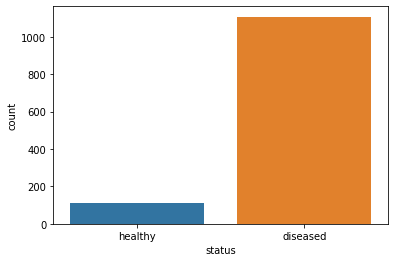

In [8]:
import seaborn as sns
counts = data['status'].value_counts()
print("The proportion of healthy/diseased is: {}".format(counts['healthy'] / counts['diseased']))
sns.countplot(data['status'])

Due to the high number of genes that we are considering is impossible to visualize their distribution. Instead I opted to visualize the distribution of the top five genes (ranked by mutual information) and the scatterplots and of each pair of them, stratifying by label (healthy/diseased)


#### Distribution of FPKM

We can see that the distribution of the genes is remarkably different in the two labels. This suggests that using mutual information as a criterion for selecting the genes to use for classification may be a correct choice.

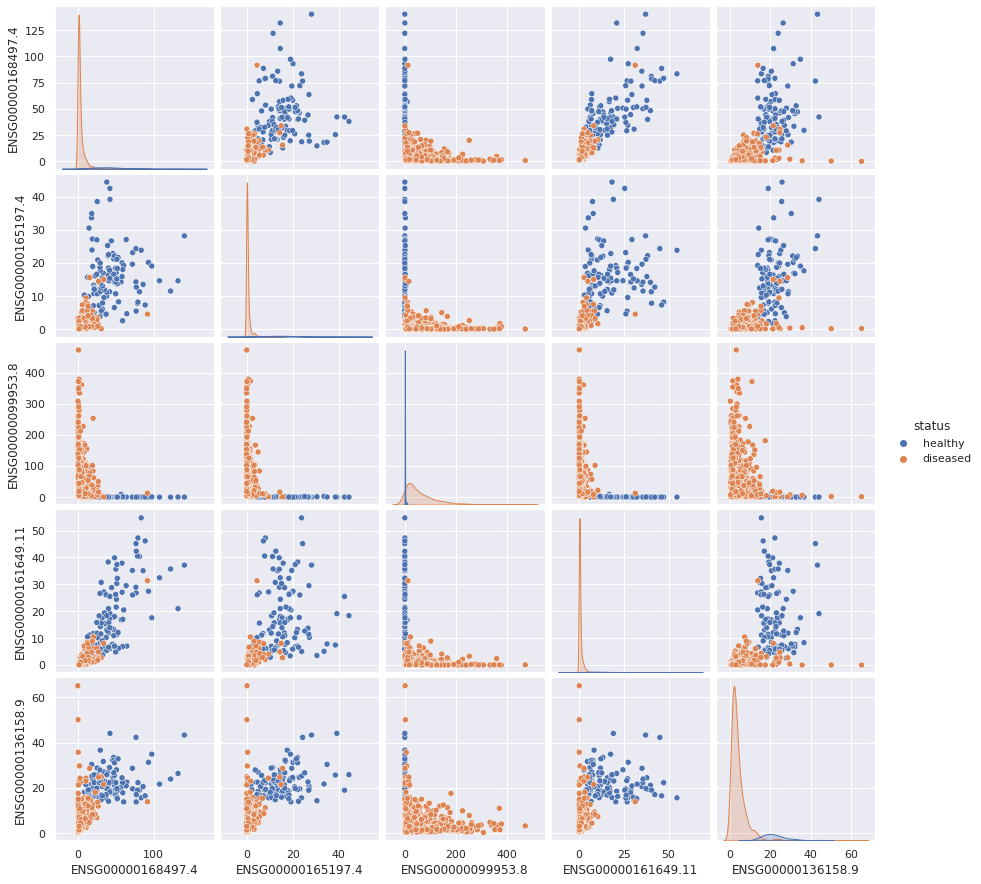

In [9]:
best_genes_full_data = get_top_genes_mi(data = data, ntop = 100)
best_genes_top_5 = best_genes_full_data[0:5]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.pairplot(data[['status', *best_genes_top_5]], hue = 'status')

We can also visualize a boxplot representing the distribution of the FPKM for the top 5 genes. This again suggests that there is a difference in  the expression levels between samples from diseased vs healthy individuals. 

<AxesSubplot:xlabel='Status', ylabel='FPKM'>

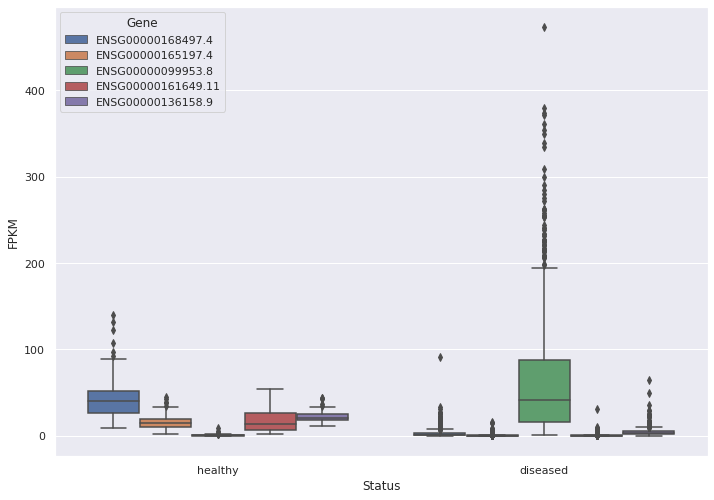

In [10]:
top_5_long = pd.melt(data[['status', *best_genes_top_5]], id_vars=['status'])
top_5_long.rename(columns = {'status':'Status', 'value':'FPKM', 'variable':'Gene'}, inplace = True)
sns.boxplot(data  = top_5_long, x = 'Status', y = 'FPKM', hue = 'Gene')

#### Correlation


The heatmap of the correlation matrix of all the genes suggests that there is a strong correlation between the expression levels of the considered genes. This may be a problem for some classification technique and needs to be taken in mind when analyzing the result of such techniques.

<AxesSubplot:>

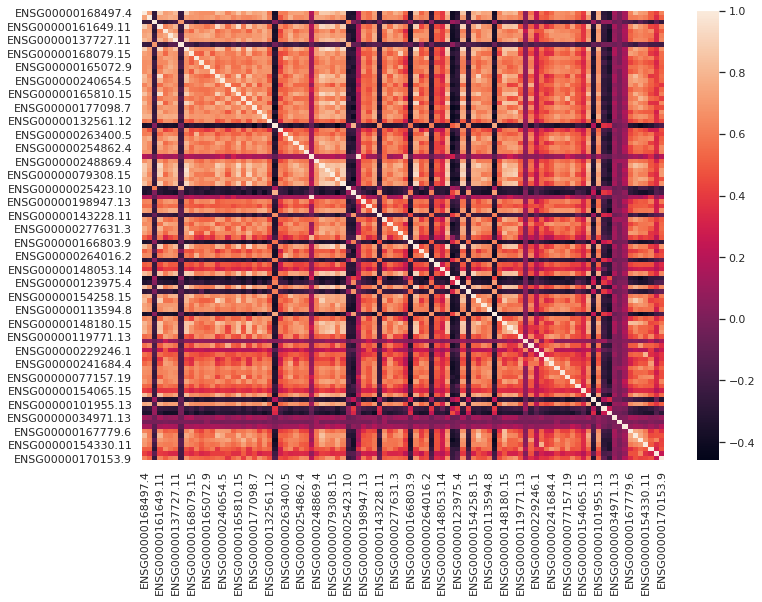

In [11]:
sns.heatmap(data[best_genes_full_data].corr())

# Data analysis

The model selection procedure is as follows:
1) The data will be split in a test and a training set randomly (30% test and 70% train)
2) The models will be trained and the following scoring metrics will be computed by 10 fold cross-validation and using the test set
    - Accuracy
    - Precision
    - Recall
    - R^2
4) All the scores will be compared (both CV and test)  
5) The final model will be the one with the best R^2 score on cross validation
6) The estimation of performance of the selected model will be the scores calculated using the test set


The models that will be trained are
1) Logistic regressor
2) Logistic regressor with lasso shrinkage
3) Linear discriminant analysis
4) Quadratic discriminant analysis

## Logistic regression
### Naive approach
For this first model we are going to train a logistic regressor using the top 50 features given by the univariate mutual information score

This will probably lead to an over fitting problem, due to the quantity of features in respect to the observation that we have. To test this hypothesis I will split the dataset in 2: a training and a testing portion. The testing portion will be used only to compute the scores and the training one only to fit the model

In [12]:
#First lets define some utility function to calculate and print
#some metrics that we will use to benchmark our models

#imports needed to train and assest the models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold


#Calculates the confusion matrix
def calculate_cm(y_test, y_pred):
    return(pd.DataFrame(data = confusion_matrix(y_test, y_pred), 
                               columns = ['True 0', 'True 1'],
                               index = ['Predicted 0', 'Predicted 1']))


#Calculates the evaluation metrices
def calculate_print_metrics(X_test, y_test, X_train, y_train, model, model_name):
    #getting predictions
    y_pred = model.predict(X_test)
    y_pred_training = model.predict(X_train)
    
    #calculating metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)   
    model_metrics_test = pd.Series([accuracy, precision, recall, r2], name = model_name,
                        index = ['Accuracy','Precision','Recall','R^2'])

    #calculating cross-validate metrics
    cv = StratifiedKFold(n_splits = 10)
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1, scoring="accuracy")
    cv_precision = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1, scoring="precision")
    cv_recall = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1, scoring="recall")
    cv_r2 = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1, scoring="r2")
    model_metrics_cv = pd.DataFrame({'CV_Accuracy' : cv_accuracy,
                                  'CV_Precision' : cv_precision,
                                  'CV_Recall' : cv_recall,
                                  'CV_r2' : cv_r2,
                                  'model' : model_name})

    #print them 
    print("Metrics for the model: {}".format(model_name))
    print("Cross validate metrics".format(model_name))
    print(model_metrics_cv.mean())
    print("Test set metrics".format(model_name))
    print("Test accuracy: {:.3f}".format(model_metrics_test['Accuracy']))
    print("Test precision: {:.3f}".format(model_metrics_test['Precision']))
    print("Test recall: {:.3f}".format(model_metrics_test['Recall']))
    print("Test R^2: {:.3f}".format(model_metrics_test['R^2']))
    print("Train R^2: {:.3f}".format(f1_score(y_train, model.predict(X_train))))

    #print confusion matrix
    co = calculate_cm(y_test, y_pred)
    print("\nConfunsion Matrix:\n {}".format(co))
    
    return(pd.DataFrame(model_metrics_test).transpose(), model_metrics_cv)

In [13]:
import sklearn
from sklearn.model_selection import train_test_split

#splitting the dataset into the features matrix and outcome vector
ntop = 50
best_genes_top_selection = get_top_genes_mi(data = data, ntop = ntop)
data_sample = data[[*best_genes_top_selection, 'status']].sample(frac = 1, random_state = 43)

X = data_sample.drop(['status'], axis = 1).to_numpy(dtype=np.float32)
y = data_sample['status'].to_numpy()
y = np.where(y == 'healthy', 0, 1)

#creating test and train dataset
split_seed = 42
split_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = split_seed,
                                                   test_size = split_size)


#traning the model 
pipe_logistic = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))
model_logistic = pipe_logistic.fit(X_train, y_train)                        

#Getting metrices for evaulation
models_metricses_test, models_metricses_cv = calculate_print_metrics(X_test, y_test, X_train, y_train, model_logistic, "Logistic")

Metrics for the model: Logistic
Cross validate metrics
CV_Accuracy     0.993857
CV_Precision    0.998876
CV_Recall       0.994344
CV_r2           0.928763
dtype: float64
Test set metrics
Test accuracy: 0.984
Test precision: 0.991
Test recall: 0.991
Test R^2: 0.792
Train R^2: 0.999

Confunsion Matrix:
              True 0  True 1
Predicted 0      19       2
Predicted 1       2     222


It can be seen that the test R^2 score is lower by ~20%. This is an indication that we over fitted the model. We can try to solve this problem by using Lasso regression in the next section 

## Lasso regression
Using lasso we can perform feature selection and see if the over fitting problem is solved.

As first thing let's plot the coefficients of the regressor for different values of the lambda hyper parameter. Observing the plotted graph we can see that many coefficients got shrunk when using a low value for C.

The next block is just to visualize the effect of the shrinkage term, it takes quite some time to compute so if you want to disable it decomment the line `lasso_visualization = False` in the block.

In [14]:
%%capture
#if you want to disable the visualization of the shrinkage term effect 
lasso_visualization = True
#lasso_visualization = False

if(lasso_visualization):
    #C = 1 / lambda
    C_vals = np.linspace(1e-4, 0.5, 100)
    betas = []
    X_std =  StandardScaler().fit_transform(X_train)

    #fit the model for each C to retrieve the beta to plot
    for C in C_vals:
        model = LogisticRegression(fit_intercept=False, max_iter=10000, solver='saga', penalty='l1', C=C, class_weight='balanced')
        model.fit(X_std, y_train)
        beta = model.coef_.reshape(-1)
        betas.append(beta)

    betas = np.stack(betas, axis=1) 

    #construct the dataframe to plot
    lasso_results = []
    c_val = pd.Series(C_vals, name = 'c_val')
    for b, gene in zip(betas, best_genes_top_selection):
        d = {'c_val': c_val, 'beta': b, 'gene': gene}
        df_resutl = pd.DataFrame(d)
        lasso_results.append(df_resutl)
    lasso_results = pd.concat(lasso_results)

<AxesSubplot:xlabel='c_val', ylabel='beta'>

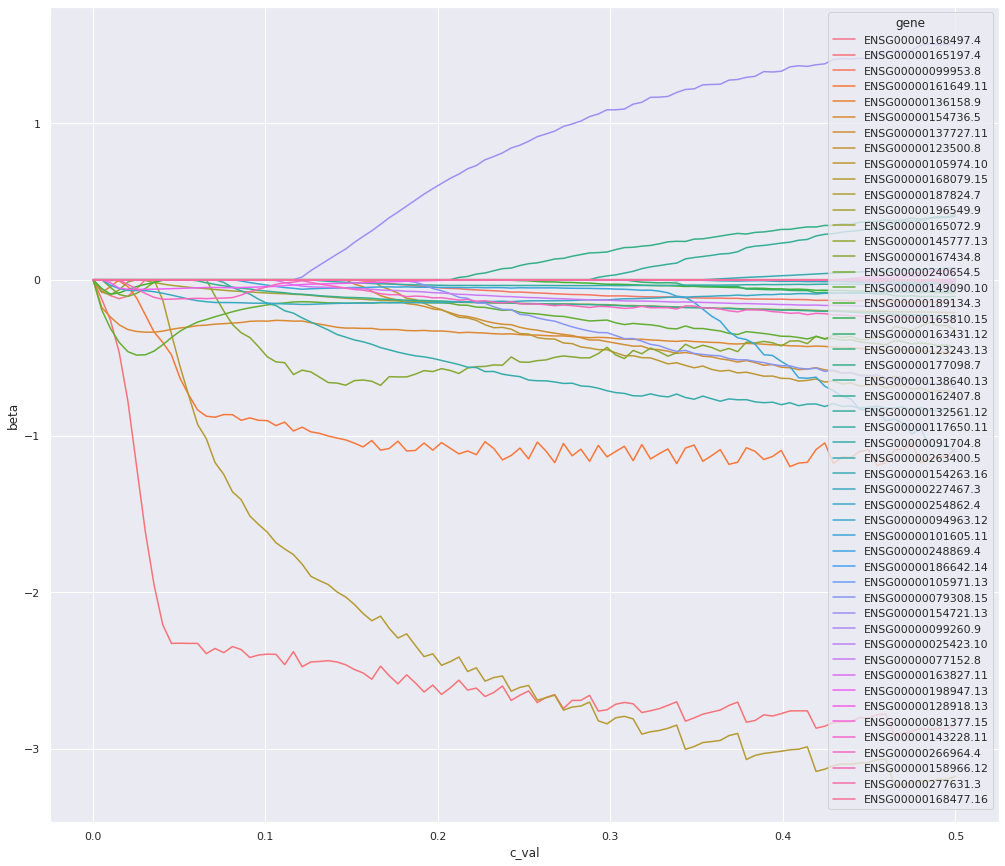

In [15]:
#cells splitted so the plot is shown 
if(lasso_visualization):
    sns.set(rc={'figure.figsize':(17,15)})
    sns.lineplot(data = lasso_results, x = 'c_val', y = 'beta', hue = 'gene')

## Finding the best lambda using cross validation
To obtain the final model the process is as follows
1) Tune the value of lambda using cross validation
2) Fit the model using the parameters that did not get shrunk to zero by the lasso regression
3) Compute the score metrics

In [16]:
#tuning the hyper parameter
from sklearn.linear_model import LassoCV
#find the best value of C using 10-cv
pipe_lassoCV = make_pipeline(StandardScaler(), LassoCV(cv = 10, n_jobs = -1))
model = pipe_lassoCV.fit(X_train, y_train)
selected_genes = pd.Series(best_genes_top_selection)[(model.named_steps['lassocv'].coef_ != 0)].tolist()

#re-train the model
pipe_lasso_final = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))
#creating the new dataset
X = data_sample.loc[:,selected_genes].to_numpy(dtype=np.float32)
X_train_lasso, X_test_lasso, y_train, y_test = train_test_split(X, y, random_state = split_seed,
                                                   test_size = split_size)

#fitting
model_lasso_final = pipe_lasso_final.fit(X_train_lasso, y_train)

#Evaluation
model_metrics_test, model_metrics_cv = calculate_print_metrics(X_test_lasso, y_test, X_train_lasso, y_train, model_lasso_final, "Lasso")
models_metricses_test = models_metricses_test.append(model_metrics_test)
models_metricses_cv = models_metricses_cv.append(model_metrics_cv)

Metrics for the model: Lasso
Cross validate metrics
CV_Accuracy     0.994887
CV_Precision    1.000000
CV_Recall       0.994344
CV_r2           0.941010
dtype: float64
Test set metrics
Test accuracy: 0.988
Test precision: 0.996
Test recall: 0.991
Test R^2: 0.844
Train R^2: 0.998

Confunsion Matrix:
              True 0  True 1
Predicted 0      20       1
Predicted 1       2     222


Using lasso there is an improvement in the test R^2 


We can visualize the boxplot representing the distribution of the FPKM for the genes selected using lasso regression. We can see that these distributions vary greatly between diseased and healthy individuals.

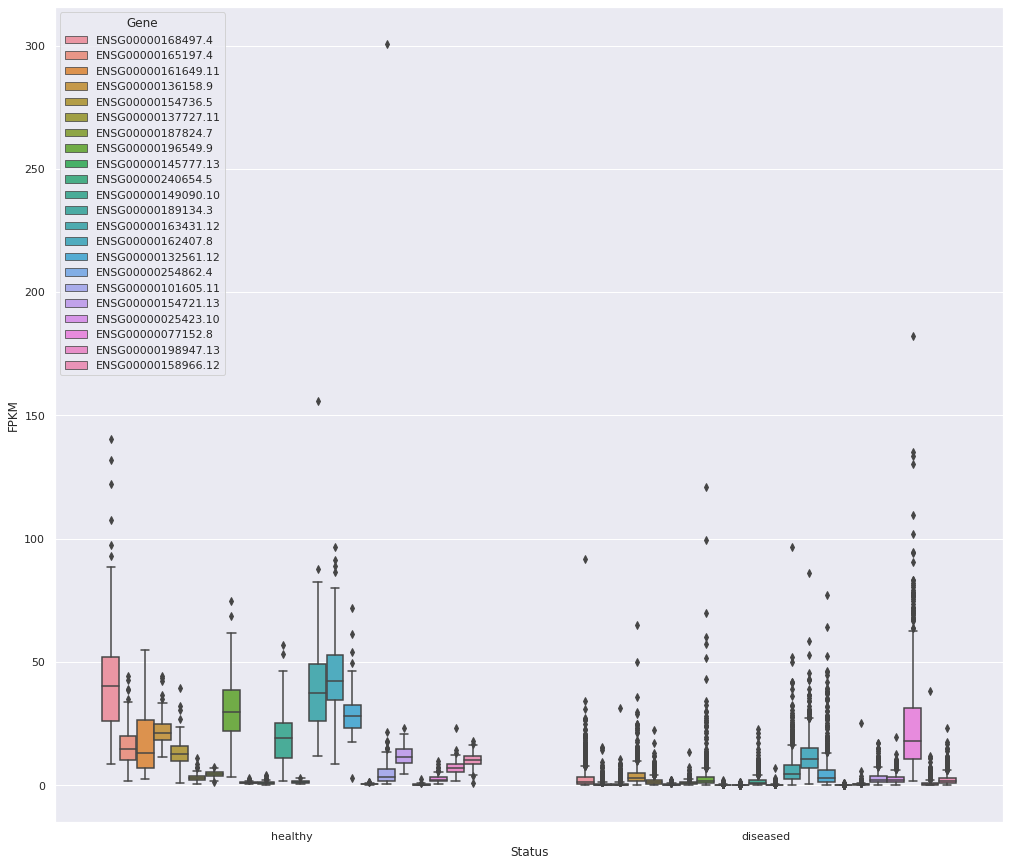

In [17]:
from_lasso = pd.melt(data[['status', *selected_genes]], id_vars=['status'])
from_lasso.rename(columns = {'status':'Status', 'value':'FPKM', 'variable':'Gene'}, inplace = True)
plt = sns.boxplot(data  = from_lasso, x = 'Status', y = 'FPKM', hue = 'Gene')
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Discriminant analysis

### Linear discriminant analysis
Linear discriminant analysis uses the Bayes theorem to compute an approximation of the Bayes classifier. It assumes that the points come from a multivariate Gaussian distribution with a fixed variance 

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 
#fitting
lda_pipe = make_pipeline(StandardScaler(), LDA())
lda_model = lda_pipe.fit(X_train, y_train)

#Evaluation
model_metrics_test, model_metrics_cv = calculate_print_metrics(X_test, y_test, X_train, y_train, lda_model, "LDA")
models_metricses_test = models_metricses_test.append(model_metrics_test)
models_metricses_cv = models_metricses_cv.append(model_metrics_cv)

Metrics for the model: LDA
Cross validate metrics
CV_Accuracy     0.989775
CV_Precision    0.996642
CV_Recall       0.992097
CV_r2           0.879824
dtype: float64
Test set metrics
Test accuracy: 0.984
Test precision: 0.987
Test recall: 0.996
Test R^2: 0.792
Train R^2: 0.998

Confunsion Matrix:
              True 0  True 1
Predicted 0      18       3
Predicted 1       1     223


### Quadratic discriminant analysis
Quadratic discriminant analysis does not have the same assumption that all the features have the same variance thus is a more flexible model

In [19]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA 
#fitting
qda_pipe = make_pipeline(StandardScaler(), QDA())
qda_model = qda_pipe.fit(X_train, y_train)

#Evaluation
model_metrics_test, model_metrics_cv = calculate_print_metrics(X_test, y_test, X_train, y_train, qda_model, "QDA")
models_metricses_test = models_metricses_test.append(model_metrics_test)
models_metricses_cv = models_metricses_cv.append(model_metrics_cv)

Metrics for the model: QDA
Cross validate metrics
CV_Accuracy     0.990785
CV_Precision    0.998889
CV_Recall       0.990947
CV_r2           0.892046
dtype: float64
Test set metrics
Test accuracy: 0.984
Test precision: 1.000
Test recall: 0.982
Test R^2: 0.792
Train R^2: 0.997

Confunsion Matrix:
              True 0  True 1
Predicted 0      21       0
Predicted 1       4     220


## Model comparisons


Taking a look at the scores, in the next tables and graphs, computed by 10-fold cross validation we can see which model performed better. As we can see from the plot of the scores with their confidence intervals we do not have a clear winner and the CIs for the different scores overlap with each other. If we take into account the point estimates we can see that the best performing model was the lasso logistic regressor with a point estimate R^2 score of 0.96 followed by the logisitc regressor with an R^2 score of 0.95 and then the LDA and QDA models. Looking at the standard errors on this values is clear that this is not a decisive result and further analysis is required, possibly increasing the sample size to have more precise estimation of the parameters and error components.

<AxesSubplot:xlabel='metric', ylabel='value'>

10-fold cross validation mean:


,CV_Accuracy,CV_Precision,CV_Recall,CV_r2
model,,,,
LDA,0.989775,0.996642,0.992097,0.879824
Lasso,0.994887,1.000000,0.994344,0.941010
Logistic,0.993857,0.998876,0.994344,0.928763
QDA,0.990785,0.998889,0.990947,0.892046


10-fold cross validation standard deviation:


,CV_Accuracy,CV_Precision,CV_Recall,CV_r2
model,,,,
LDA,0.008332,0.005407,0.009300,0.097110
Lasso,0.007224,0.000000,0.008015,0.081478
Logistic,0.007148,0.003553,0.008015,0.080828
QDA,0.011297,0.003514,0.012869,0.132447


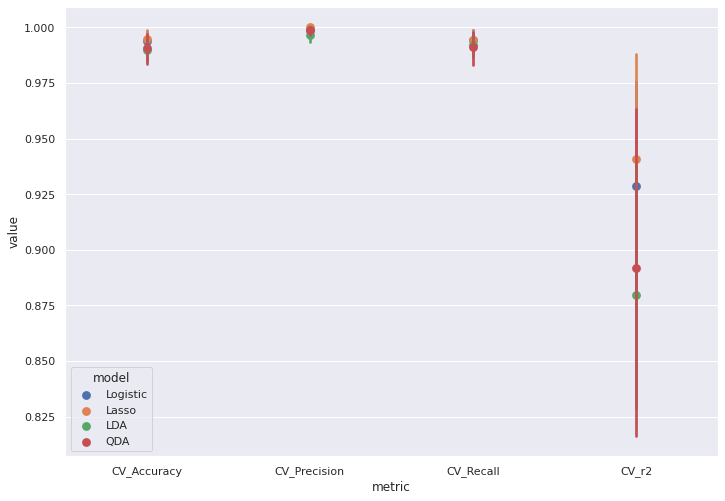

In [20]:
metrics = models_metricses_cv.melt(id_vars = 'model', var_name = 'metric')
sns.pointplot(data = metrics, x = 'metric', y = 'value', hue = 'model', linestyles='') 

print("10-fold cross validation mean:")
models_metricses_cv.groupby('model').mean()
print("10-fold cross validation standard deviation:")
models_metricses_cv.groupby('model').std()

As we can see from the scatterplot the logistic regressor with the lasso shrinkage appears to have performed better on the test set with an R^2 score of 0.84, followed by the logistic regressor without penalties. The third place for the R^2 score on the test set is the linear discriminant analysis and last the QDA

<AxesSubplot:>

,Accuracy,Precision,Recall,R^2
Logistic,0.983673,0.991071,0.991071,0.791667
Lasso,0.987755,0.995516,0.991071,0.843750
LDA,0.983673,0.986726,0.995536,0.791667
QDA,0.983673,1.000000,0.982143,0.791667


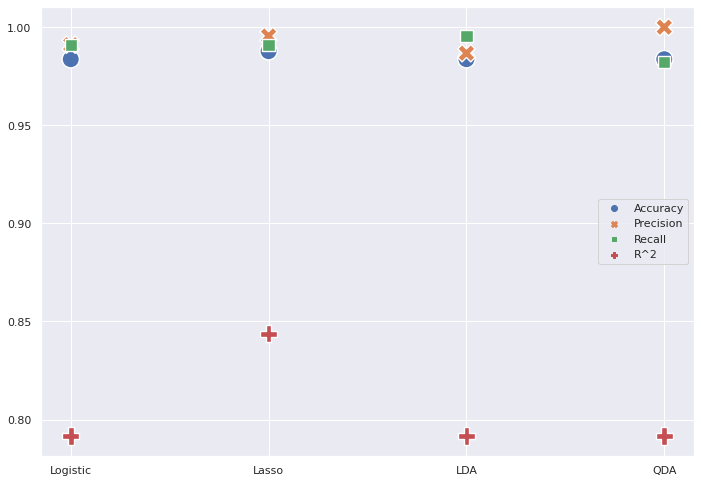

In [21]:
sns.scatterplot(data = models_metricses_test, s=300)
models_metricses_test

## Conclusions

From the analysis that was performed in this notebooks appears that the lasso logistic regressor performed better on this data set than the other models although, a more in-depth analysis, possibly enlarging the sample size, is required to confirm this as the confidence intervals (at level alpha = 95%) for all the relevant metrics for each model overlapped each other.